In [1]:
%load_ext sparkmagic.magics

Cleaning up livy sessions on exit is enabled


In [2]:
%reload_ext sparkmagic.magics

Cleaning up livy sessions on exit is enabled


In [3]:
%spark cleanup

In [4]:
%%spark config
{
    "name": "cdigital",
    "driverCores": 2,
    "driverMemory": "4g",
    "executorCores":2,
    "executorMemory": "4g",
    "numExecutors": 2
}

In [5]:
%spark add -s cdigital -l python -u http://ip-10-120-43-81.ec2.internal:8998/ -t Kerberos -k

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
50,application_1741921212620_0586,pyspark,idle,Link,Link,datascience,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [6]:
%%spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from datetime import datetime
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import (
    col,
    max,
    min,
    sum,
    first,
    count,
    when,
    lit,
    expr,
    to_date,
    to_timestamp,
    datediff,
    current_date,
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
import pandas as pd
import numpy as np
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
!pip install openpyxl

In [11]:
%%spark
s3_path = "s3://culqi-datascience-423011959496/proyecto_canal_digital/input/reporte-feb.parquet"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
s3_path = "s3://culqi-datascience-423011959496/proyecto_canal_digital/input/reporte_por_meses.xlsx"
df = pd.read_excel(s3_path, storage_options={"anon": False},dtype={"Tiempo de resolución de ticket":str,"Fecha y hora de primera asignación del ticket al usuario": str, "Tiempo de primera respuesta": str})

# primera fila
print(df.head(3))

   Número de Ticket  ID de interacción Tipo de interacción  \
0           1026080             478365            Entrante   
1           1026078             478364            Entrante   
2           1026077             478363            Entrante   

  Fecha y hora de creación del ticket  \
0             2025-03-07 23:51:22.420   
1             2025-03-07 23:37:55.637   
2             2025-03-07 23:33:12.063   

  Fecha y hora de creación de la interacción  \
0                    2025-03-07 23:51:22.436   
1                    2025-03-07 23:37:55.651   
2                    2025-03-07 23:33:12.079   

  Fecha y hora de primera asignación del ticket al usuario  \
0                                                NaN         
1                                                NaN         
2                                                NaN         

  Fecha y hora de asignación a la cola Fecha y hora de primera respuesta  \
0                                  NaT                              

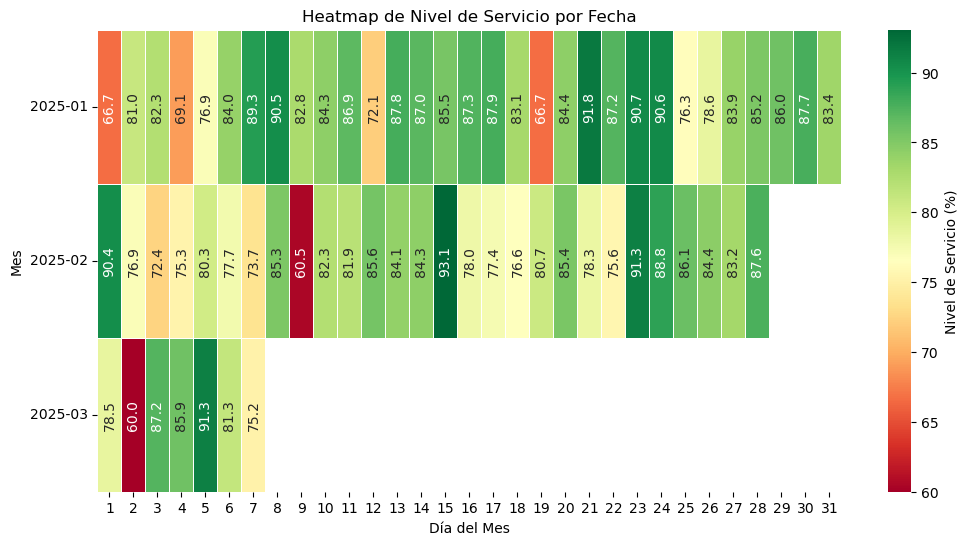

In [11]:

df["Tiempo de resolución de ticket"] = pd.to_timedelta(df["Tiempo de resolución de ticket"], errors="coerce")
df["Fecha y hora de primera asignación del ticket al usuario"] = pd.to_datetime(df["Fecha y hora de primera asignación del ticket al usuario"], errors="coerce")
df["Fecha y hora de primera respuesta"] = pd.to_datetime(df["Fecha y hora de primera respuesta"], errors="coerce")
df["Tiempo de primera respuesta"] = pd.to_timedelta(df["Tiempo de primera respuesta"], errors="coerce")
#df = df[df["Tiempo de resolución de ticket"] <= pd.Timedelta("01:00:00")]

#filtros de canal digital
df = df[(df["Campaña"] == "Canal Digital") & (df["Tipo de interacción"] == "Entrante")]
df_digital = df[df["Cola Asignada"] == "ATCDigital"].copy()

#calculo de nivel de satisfaccion
df_digital["Tiempo de respuesta"] = (df_digital["Fecha y hora de primera respuesta"] - df_digital["Fecha y hora de primera asignación del ticket al usuario"]).dt.total_seconds()


df_digital["Fecha"] = df_digital["Fecha y hora de primera asignación del ticket al usuario"].dt.date
df_digital["Mes"] = df_digital["Fecha y hora de primera asignación del ticket al usuario"].dt.month


fecha_inicio = pd.to_datetime("2025-01-01").date()
fecha_fin = pd.to_datetime("2025-03-09").date()
df_digital = df_digital[(df_digital["Fecha"] >= fecha_inicio) & (df_digital["Fecha"] <= fecha_fin)]

# nivel de servicio agrupando
niveles_servicio_por_dia = {}
for fecha, df_dia in df_digital.groupby("Fecha"):
    chats_respondidos_90s = df_dia[df_dia["Tiempo de respuesta"] <= 90].shape[0]
    chats_totales = df_dia.shape[0]
    #formula nivel de servicio
    nivel_servicio = (chats_respondidos_90s / chats_totales) * 100 if chats_totales > 0 else 0 
    niveles_servicio_por_dia[fecha] = nivel_servicio


df_niveles = pd.DataFrame(list(niveles_servicio_por_dia.items()), columns=["Fecha", "Nivel de Servicio"])
df_niveles["Fecha"] = pd.to_datetime(df_niveles["Fecha"])
df_niveles["Día"] = df_niveles["Fecha"].dt.day
df_niveles["Mes"] = df_niveles["Fecha"].dt.strftime("%Y-%m")

heatmap_data = df_niveles.pivot(index="Mes",columns= "Día",values= "Nivel de Servicio")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Nivel de Servicio (%)'}, annot_kws={"rotation": 90})
plt.title("Heatmap de Nivel de Servicio por Fecha")
plt.xlabel("Día del Mes")
plt.ylabel("Mes")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


## Reporte nivel de servicio en febrero por 1 hora

In [12]:
s3_feb = "s3://culqi-datascience-423011959496/proyecto_canal_digital/input/reporte-feb.xlsx"
df = pd.read_excel(s3_feb, storage_options={"anon": False},dtype={"Tiempo de resolución de ticket":str,"Fecha y hora de primera asignación del ticket al usuario": str, "Tiempo de primera respuesta": str})
print(df.head(3))

   Número de Ticket  ID de interacción Tipo de interacción  \
0          998866.0           468264.0            Entrante   
1          998865.0           468263.0            Entrante   
2          998864.0           468262.0            Entrante   

  Fecha y hora de creación del ticket  \
0             2025-02-28 22:58:34.318   
1             2025-02-28 22:50:57.835   
2             2025-02-28 22:46:58.505   

  Fecha y hora de creación de la interacción  \
0                    2025-02-28 22:58:34.333   
1                    2025-02-28 22:50:57.847   
2                    2025-02-28 22:46:58.518   

  Fecha y hora de primera asignación del ticket al usuario  \
0                                                NaN         
1                                                NaN         
2                         2025-03-01 09:10:07.451000         

  Fecha y hora de asignación a la cola Fecha y hora de primera respuesta  \
0                                  NaT                              

/tmp/ipykernel_180/3934497976.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["Hora"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.floor("60T").dt.strftime('%H:%M')
/tmp/ipykernel_180/3934497976.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio = df.groupby(["Hora", "Día"])["Tiempo de respuesta"].apply(lambda x: (x <= 90).mean() * 100).reset_index(name="Nivel de Servicio")


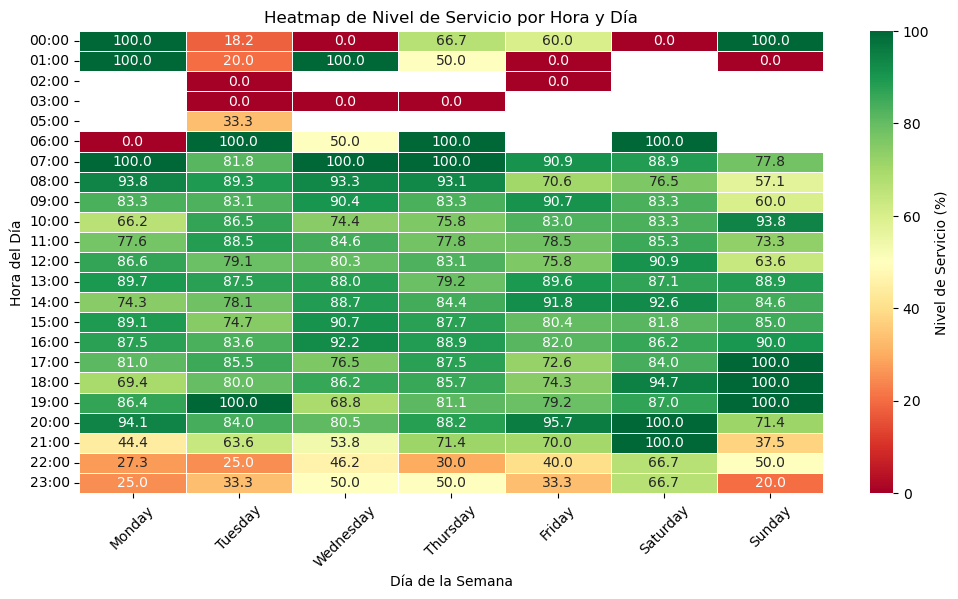

In [13]:
# formato
df["Fecha y hora de primera asignación del ticket al usuario"] = pd.to_datetime(df["Fecha y hora de primera asignación del ticket al usuario"], errors="coerce")
df["Fecha y hora de primera respuesta"] = pd.to_datetime(df["Fecha y hora de primera respuesta"], errors="coerce")
# Filtros de canal digital
df = df[(df["Campaña"] == "Canal Digital") & (df["Tipo de interacción"] == "Entrante") & (df["Cola Asignada"] == "ATCDigital")]

# cálculo de chats con 90s
df["Tiempo de respuesta"] = (df["Fecha y hora de primera respuesta"] - df["Fecha y hora de primera asignación del ticket al usuario"]).dt.total_seconds()

# filtro febrero
df["Fecha"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.date
df = df[(df["Fecha"] >= pd.to_datetime("2025-02-01").date()) & (df["Fecha"] <= pd.to_datetime("2025-02-28").date())]

# extraer hora (cada 60 min) y día
df["Hora"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.floor("60T").dt.strftime('%H:%M')
# filtro horarios
df = df[(df["Fecha y hora de primera asignación del ticket al usuario"].dt.hour >= 0) &
        (df["Fecha y hora de primera asignación del ticket al usuario"].dt.hour <= 24)]
df["Día"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.day_name()
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Día"] = pd.Categorical(df["Día"], categories=dias_orden, ordered=True)

# Nivel de Servicio por Hora y Día
niveles_servicio = df.groupby(["Hora", "Día"])["Tiempo de respuesta"].apply(lambda x: (x <= 90).mean() * 100).reset_index(name="Nivel de Servicio")


heatmap_data = niveles_servicio.pivot(index="Hora", columns="Día", values="Nivel de Servicio")


plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Nivel de Servicio (%)'})
plt.title("Heatmap de Nivel de Servicio por Hora y Día")
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Reporte nivel de servicio de febrero por 30 minutos

/tmp/ipykernel_180/3589394166.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["Hora"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.floor("30T").dt.strftime('%H:%M')
/tmp/ipykernel_180/3589394166.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio = df.groupby(["Hora", "Día"])["Tiempo de respuesta"].apply(lambda x: (x <= 90).mean() * 100).reset_index(name="Nivel de Servicio")


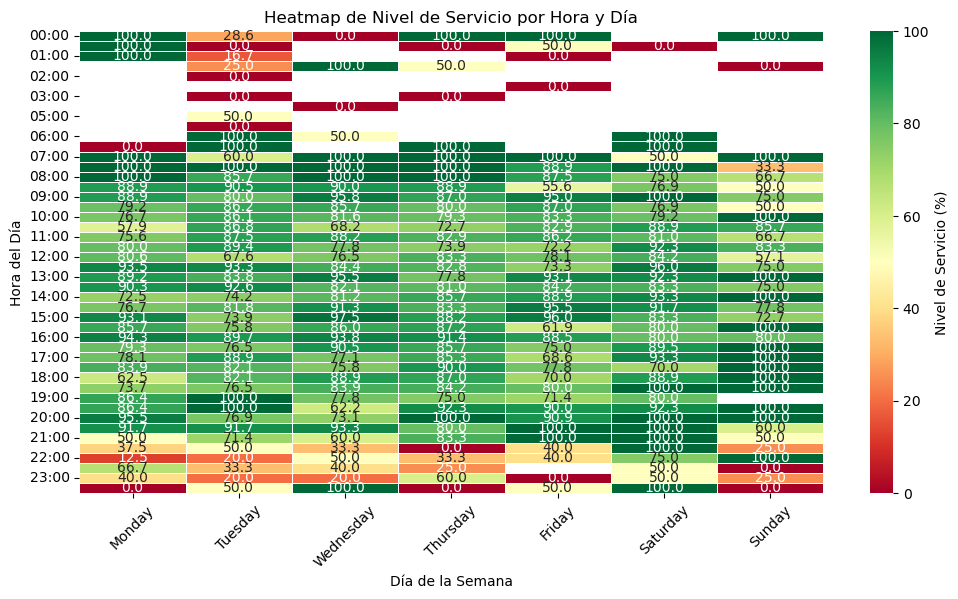

In [14]:

# formato
df["Fecha y hora de primera asignación del ticket al usuario"] = pd.to_datetime(df["Fecha y hora de primera asignación del ticket al usuario"], errors="coerce")
df["Fecha y hora de primera respuesta"] = pd.to_datetime(df["Fecha y hora de primera respuesta"], errors="coerce")
# Filtros
df = df[(df["Campaña"] == "Canal Digital") & (df["Tipo de interacción"] == "Entrante") & (df["Cola Asignada"] == "ATCDigital")]

# cálculo tiempo de respuesra
df["Tiempo de respuesta"] = (df["Fecha y hora de primera respuesta"] - df["Fecha y hora de primera asignación del ticket al usuario"]).dt.total_seconds()

# filtro febrero
df["Fecha"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.date
df = df[(df["Fecha"] >= pd.to_datetime("2025-02-01").date()) & (df["Fecha"] <= pd.to_datetime("2025-02-28").date())]

# extraer hora (cada 30 min) y día
df["Hora"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.floor("30T").dt.strftime('%H:%M')
# filtro horarios
df = df[(df["Fecha y hora de primera asignación del ticket al usuario"].dt.hour >= 0) &
        (df["Fecha y hora de primera asignación del ticket al usuario"].dt.hour <= 24)]
df["Día"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.day_name()
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Día"] = pd.Categorical(df["Día"], categories=dias_orden, ordered=True)

# Nivel de Servicio por Hora y Día
niveles_servicio = df.groupby(["Hora", "Día"])["Tiempo de respuesta"].apply(lambda x: (x <= 90).mean() * 100).reset_index(name="Nivel de Servicio")


heatmap_data = niveles_servicio.pivot(index="Hora", columns="Día", values="Nivel de Servicio")


plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Nivel de Servicio (%)'})
plt.title("Heatmap de Nivel de Servicio por Hora y Día")
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Reporte de nivel de servicio de febrero por días

In [19]:
df["Semana"] = df["Fecha y hora de primera asignación del ticket al usuario"].dt.isocalendar().week
df["Semana"] = df["Semana"] - df["Semana"].min() + 1  


/tmp/ipykernel_180/1730738421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \


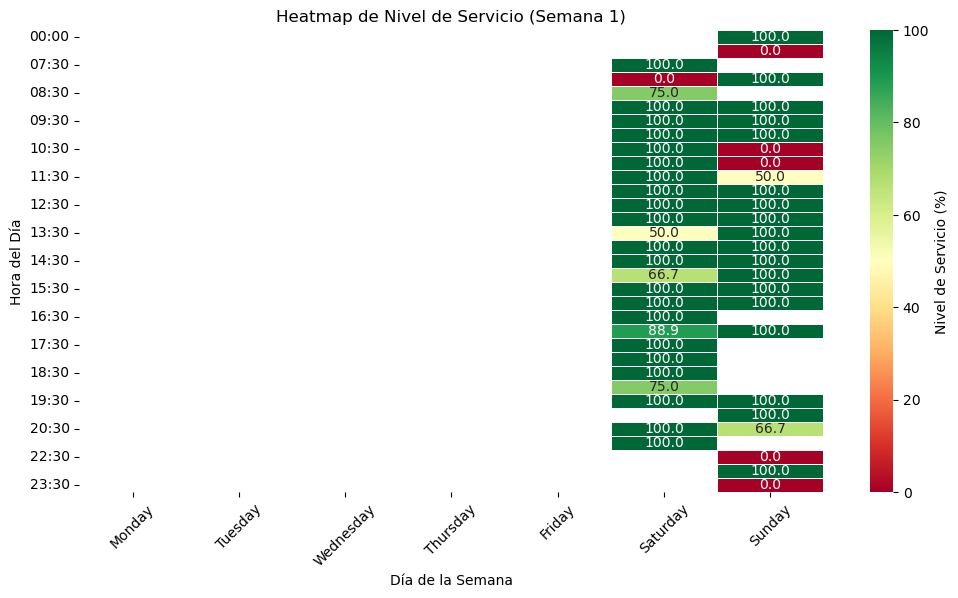

/tmp/ipykernel_180/1730738421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \


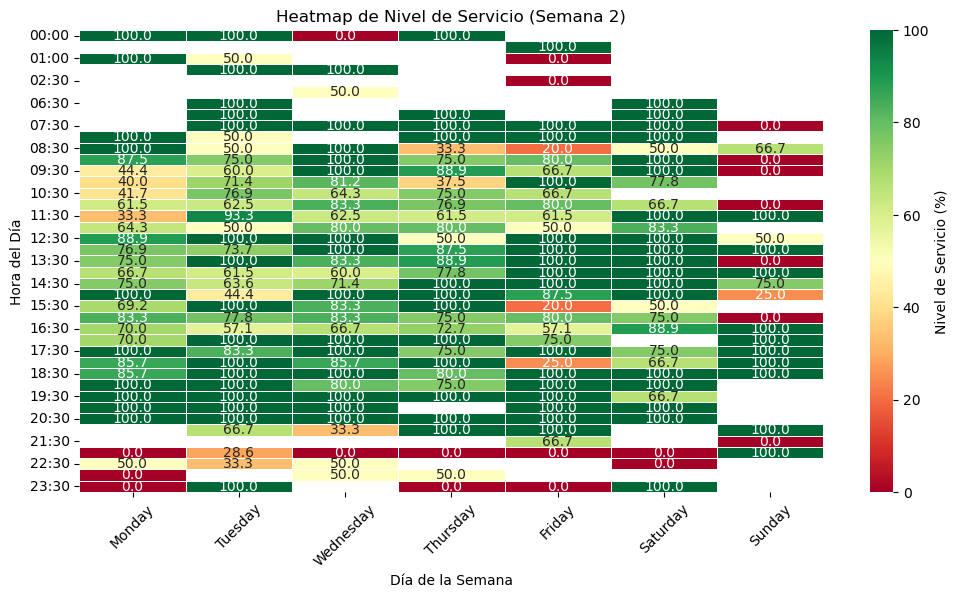

/tmp/ipykernel_180/1730738421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \


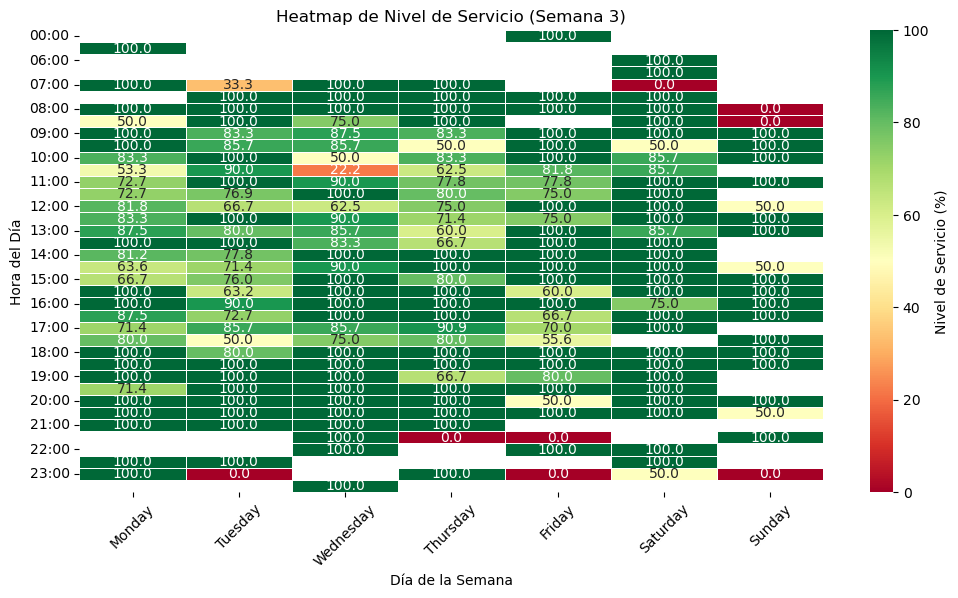

/tmp/ipykernel_180/1730738421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \


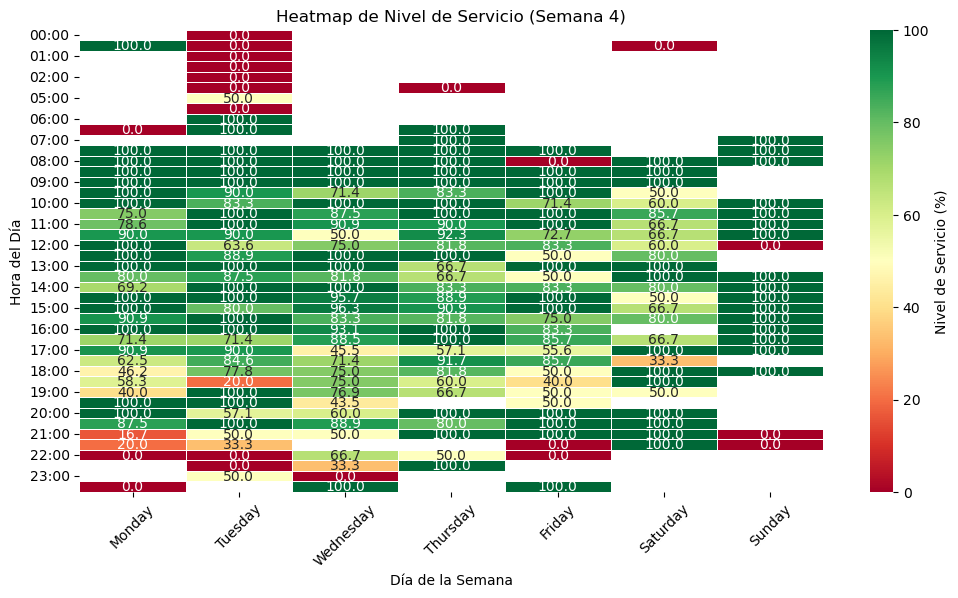

/tmp/ipykernel_180/1730738421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \


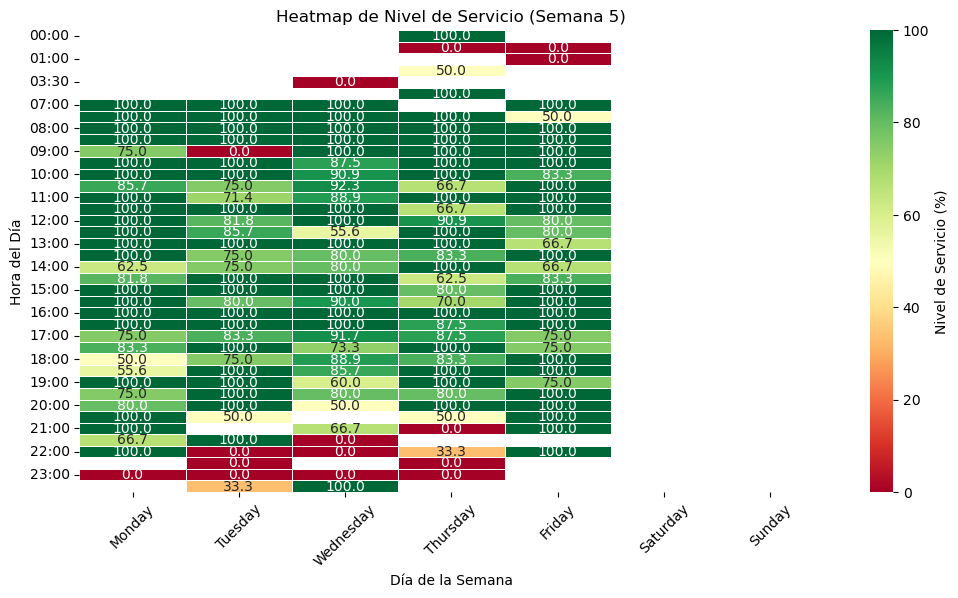

In [20]:

for semana in sorted(df["Semana"].unique()):
    df_semana = df[df["Semana"] == semana]


    niveles_servicio_semana = df_semana.groupby(["Hora", "Día"])["Tiempo de respuesta"] \
        .apply(lambda x: (x <= 90).mean() * 100).reset_index(name="Nivel de Servicio")


    heatmap_data_semana = niveles_servicio_semana.pivot(index="Hora", columns="Día", values="Nivel de Servicio")
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data_semana, cmap="RdYlGn", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Nivel de Servicio (%)'})
    plt.title(f"Heatmap de Nivel de Servicio (Semana {semana})")
    plt.xlabel("Día de la Semana")
    plt.ylabel("Hora del Día")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Mostrar gráfico
    plt.show()


## Promedio de número de tickets por día

/tmp/ipykernel_162/1760051451.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedio_tickets_por_dia.index, y=promedio_tickets_por_dia.values, palette="viridis")


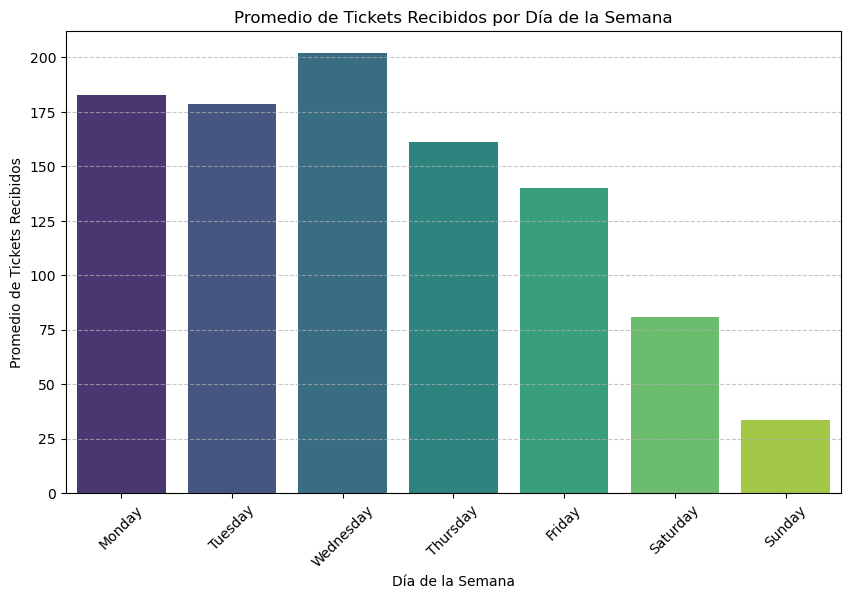

In [31]:
dias_count = df["Día"].value_counts()
promedio_tickets_por_dia = dias_count/4

dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
promedio_tickets_por_dia = promedio_tickets_por_dia.reindex(dias_orden)


plt.figure(figsize=(10, 6))
sns.barplot(x=promedio_tickets_por_dia.index, y=promedio_tickets_por_dia.values, palette="viridis")
plt.xlabel("Día de la Semana")
plt.ylabel("Promedio de Tickets Recibidos")
plt.title("Promedio de Tickets Recibidos por Día de la Semana")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Dotación (1era semana de marzo) de agentes por 30 minutos

**Disponibilidad de agentes activos por cada 30 minutos para atender Canal Digital**

In [74]:
!pip install xlsxwriter

In [22]:
import io
import boto3
import xlsxwriter

In [99]:
s3_dotacion = "s3://culqi-datascience-423011959496/proyecto_canal_digital/input/dotacion_cdigital.xlsx"
df = pd.read_excel(s3_dotacion, storage_options={"anon": False})
print(df)
#datetime_columns = ["Tiempo de resolución de ticket", "Fecha y hora de primera asignación del ticket al usuario","Tiempo de primera respuesta"]  


                             Nombre             Supervisor Centro      Fecha  \
0    Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-03   
1    Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-04   
2    Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-05   
3    Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-06   
4    Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-07   
..                              ...                    ...    ...        ...   
135          Yesenia Montanez Duran  Alex Ramirez Jauregui    DUX 2025-03-12   
136          Yesenia Montanez Duran  Alex Ramirez Jauregui    DUX 2025-03-13   
137          Yesenia Montanez Duran  Alex Ramirez Jauregui    DUX 2025-03-14   
138          Yesenia Montanez Duran  Alex Ramirez Jauregui    DUX 2025-03-15   
139          Yesenia Montanez Duran  Alex Ramirez Jauregui    DUX 2025-03-16   

    Hora de entrada Hora de salida Inic

In [100]:
import awswrangler as wr

In [101]:
print(df.dtypes) #cambio el formato de lo que es datetime 64

Nombre                          object
Supervisor                      object
Centro                          object
Fecha                   datetime64[ns]
Hora de entrada                 object
Hora de salida                  object
Inicio de refrigerio            object
Fin de refrigerio               object
Horas                           object
IH                               int64
Dia                             object
Apoyo                           object
Semana                           int64
Wave                             int64
dtype: object


In [102]:
datetime_columns = ["Fecha"]  
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

In [103]:
bucket_name = 'culqi-datascience-423011959496'
s3_file_exportar = "proyecto_canal_digital/output/dotacion_output.parquet"
df.to_parquet(f's3://{bucket_name}/{s3_file_exportar}')

In [104]:
ruta_parquet = "s3://culqi-datascience-423011959496/proyecto_canal_digital/output/dotacion_output.parquet"
df_parquet = wr.s3.read_parquet(path = ruta_parquet, dataset=False)

In [105]:
print(df_parquet.head())

                           Nombre             Supervisor Centro      Fecha  \
0  Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-03   
1  Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-04   
2  Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-05   
3  Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-06   
4  Carlos Augusto Chancafe Ñiquen  Alex Ramirez Jauregui    DUX 2025-03-07   

  Hora de entrada Hora de salida Inicio de refrigerio Fin de refrigerio  \
0        07:00:00       16:00:00             12:00:00          13:00:00   
1        07:00:00       16:00:00             12:00:00          13:00:00   
2        07:00:00       16:00:00             12:00:00          13:00:00   
3        07:00:00       16:00:00             12:00:00          13:00:00   
4        07:00:00       16:00:00             12:00:00          13:00:00   

      Horas  IH        Dia          Apoyo  Semana  Wave  
0  08:00:00  48      l

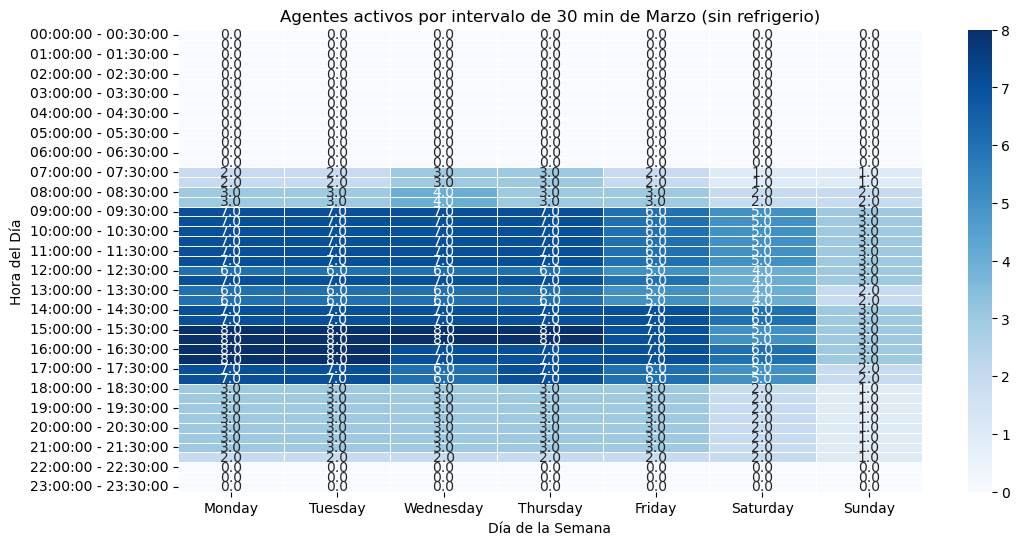

Archivo guardado en: culqi-datascience-423011959496/proyecto_canal_digital/output/cantidad_agentes_30m_sin_refrigerio.parquet


In [113]:
import awswrangler as wr

df = df_parquet
df = df[df['Apoyo'] == "Canal Digital"]

df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y", errors="coerce")
df = df[df["Fecha"] <= pd.to_datetime("2025-03-09")]

df["Hora de entrada"] = pd.to_datetime(df["Hora de entrada"], format="%H:%M:%S", errors='coerce').dt.time
df["Hora de salida"] = pd.to_datetime(df["Hora de salida"], format="%H:%M:%S", errors='coerce').dt.time
df["Inicio de refrigerio"] = pd.to_datetime(df["Inicio de refrigerio"], format="%H:%M:%S", errors='coerce').dt.time
df["Fin de refrigerio"] = pd.to_datetime(df["Fin de refrigerio"], format="%H:%M:%S", errors='coerce').dt.time


time_intervals = pd.date_range("00:00:00", "23:30:00", freq="30min").time
time_labels = [f"{time_intervals[i].strftime('%H:%M:%S')} - {time_intervals[i+1].strftime('%H:%M:%S')}" for i in range(len(time_intervals) - 1)]

dates = sorted(df["Fecha"].dropna().unique())
day_labels = [pd.Timestamp(date).strftime("%A") for date in dates]

data_matrix = []
for i in range(len(time_intervals) - 1):
    time_counts = []
    start_time = time_intervals[i]
    end_time = time_intervals[i + 1]

    for date in dates:
        df_date = df[df["Fecha"] == date]

        count = sum(
            (row["Hora de entrada"] <= start_time < row["Hora de salida"]) and
            not (row["Inicio de refrigerio"] <= start_time < row["Fin de refrigerio"])  # Excluir si está en refrigerio
            for _, row in df_date.iterrows()
        )
        time_counts.append(count)
    
    data_matrix.append(time_counts)

df_cant_agentes_30 = pd.DataFrame(data_matrix, index=time_labels, columns=day_labels)
df_cant_agentes_30 = df_cant_agentes_30.reset_index().rename(columns={"index": "hora_30m"})
df_cant_agentes_30 = df_cant_agentes_30.set_index("hora_30m").astype(float)


plt.figure(figsize=(12, 6))
sns.heatmap(df_cant_agentes, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.title(f"Agentes activos por intervalo de 30 min de Marzo (sin refrigerio)")
plt.yticks(rotation=0)
plt.show()

bucket_name = 'culqi-datascience-423011959496'
s3_file_exportar = "proyecto_canal_digital/output/cantidad_agentes_30m_sin_refrigerio.parquet"
df.to_parquet(f's3://{bucket_name}/{s3_file_exportar}')


print(f'Archivo guardado en: {bucket_name}/{s3_file_exportar}')

In [114]:
print(df_cant_agentes_30)

                     Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
hora_30m                                                                      
00:00:00 - 00:30:00     0.0      0.0        0.0       0.0     0.0       0.0   
00:30:00 - 01:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
01:00:00 - 01:30:00     0.0      0.0        0.0       0.0     0.0       0.0   
01:30:00 - 02:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
02:00:00 - 02:30:00     0.0      0.0        0.0       0.0     0.0       0.0   
02:30:00 - 03:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
03:00:00 - 03:30:00     0.0      0.0        0.0       0.0     0.0       0.0   
03:30:00 - 04:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
04:00:00 - 04:30:00     0.0      0.0        0.0       0.0     0.0       0.0   
04:30:00 - 05:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
05:00:00 - 05:30:00     0.0      0.0        0.0     

## Dotación (1ra sem de marzo) de agentes cada 1 hora

**Disponibilidad de agentes activos por cada hora para atender CanalDigital**

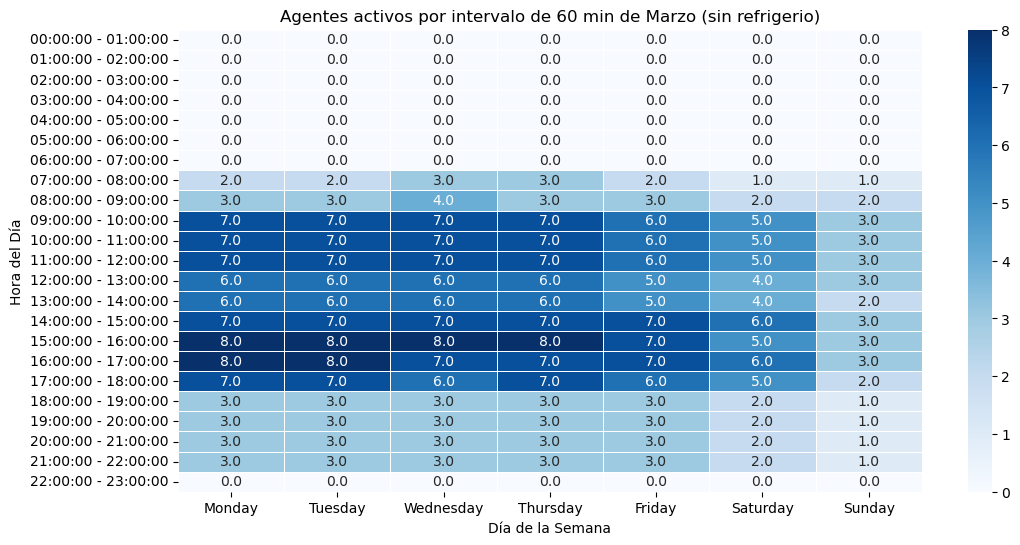

                     Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
hora_60m                                                                      
00:00:00 - 01:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
01:00:00 - 02:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
02:00:00 - 03:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
03:00:00 - 04:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
04:00:00 - 05:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
05:00:00 - 06:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
06:00:00 - 07:00:00     0.0      0.0        0.0       0.0     0.0       0.0   
07:00:00 - 08:00:00     2.0      2.0        3.0       3.0     2.0       1.0   
08:00:00 - 09:00:00     3.0      3.0        4.0       3.0     3.0       2.0   
09:00:00 - 10:00:00     7.0      7.0        7.0       7.0     6.0       5.0   
10:00:00 - 11:00:00     7.0      7.0        7.0     

In [120]:
import awswrangler as wr

df = df[df['Apoyo'] == "Canal Digital"]

df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y", errors="coerce")
df = df[df["Fecha"] <= pd.to_datetime("2025-03-09")]

df["Hora de entrada"] = pd.to_datetime(df["Hora de entrada"], format="%H:%M:%S", errors='coerce').dt.time
df["Hora de salida"] = pd.to_datetime(df["Hora de salida"], format="%H:%M:%S", errors='coerce').dt.time
df["Inicio de refrigerio"] = pd.to_datetime(df["Inicio de refrigerio"], format="%H:%M:%S", errors='coerce').dt.time
df["Fin de refrigerio"] = pd.to_datetime(df["Fin de refrigerio"], format="%H:%M:%S", errors='coerce').dt.time

time_intervals = pd.date_range("00:00:00", "23:30:00", freq="60min").time
time_labels = [f"{time_intervals[i].strftime('%H:%M:%S')} - {time_intervals[i+1].strftime('%H:%M:%S')}" for i in range(len(time_intervals) - 1)]

dates = sorted(df["Fecha"].dropna().unique())
day_labels = [pd.Timestamp(date).strftime("%A") for date in dates]

data_matrix = []
for i in range(len(time_intervals) - 1):
    time_counts = []
    start_time = time_intervals[i]
    end_time = time_intervals[i + 1]

    for date in dates:
        df_date = df[df["Fecha"] == date]

        count = sum(
            (row["Hora de entrada"] <= start_time < row["Hora de salida"]) and
            not (row["Inicio de refrigerio"] <= start_time < row["Fin de refrigerio"])  
            for _, row in df_date.iterrows()
        )
        time_counts.append(count)
    
    data_matrix.append(time_counts)

df_cant_agentes_60 = pd.DataFrame(data_matrix, index=time_labels, columns=day_labels)
df_cant_agentes_60 = df_cant_agentes_60.reset_index().rename(columns={"index": "hora_60m"})
df_cant_agentes_60 = df_cant_agentes_60.set_index("hora_60m").astype(float)


plt.figure(figsize=(12, 6))
sns.heatmap(df_cant_agentes_60, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.title(f"Agentes activos por intervalo de 60 min de Marzo (sin refrigerio)")
plt.yticks(rotation=0)
plt.show()

print(df_cant_agentes_60)
bucket_name = 'culqi-datascience-423011959496'
s3_file_exportar = "proyecto_canal_digital/output/cantidad_agentes_60m_sin_refrigerio.parquet"
df.to_parquet(f's3://{bucket_name}/{s3_file_exportar}')


print(f'Archivo guardado en: {bucket_name}/{s3_file_exportar}')


## Promedio de número de tickets recibidos cada 30 min por la semana

In [121]:
bucket_name = 'culqi-datascience-423011959496'
s3_file_exportar = "proyecto_canal_digital/input/cantidad_agentes_60m_sin_refrigerio.parquet"
df_cant_agentes.to_parquet(f's3://{bucket_name}/{s3_file_exportar}')

In [122]:
s3_path = "s3://culqi-datascience-423011959496/proyecto_canal_digital/input/reporte_marzo2.xlsx"
df_reporte = pd.read_excel(s3_path, storage_options={"anon": False})
print(df_reporte.head(3))

   Número de Ticket  ID de interacción Tipo de interacción  \
0           1029620             479416            Entrante   
1           1029619             479415            Entrante   
2           1029618             479414            Entrante   

  Fecha y hora de creación del ticket  \
0             2025-03-09 23:28:23.412   
1             2025-03-09 23:16:15.130   
2             2025-03-09 23:14:29.122   

  Fecha y hora de creación de la interacción  \
0                    2025-03-09 23:28:23.430   
1                    2025-03-09 23:16:15.144   
2                    2025-03-09 23:14:29.137   

  Fecha y hora de primera asignación del ticket al usuario  \
0                                                NaT         
1                                                NaT         
2                                                NaT         

  Fecha y hora de asignación a la cola Fecha y hora de primera respuesta  \
0                                  NaT                              

In [53]:
print(df_reporte.dtypes)

Número de Ticket                                                     int64
ID de interacción                                                    int64
Tipo de interacción                                                 object
Fecha y hora de creación del ticket                         datetime64[ns]
Fecha y hora de creación de la interacción                  datetime64[ns]
Fecha y hora de primera asignación del ticket al usuario    datetime64[ns]
Fecha y hora de asignación a la cola                        datetime64[ns]
Fecha y hora de primera respuesta                           datetime64[ns]
Fecha y hora de cierre de ticket                            datetime64[ns]
Tiempo de primera respuesta                                         object
Tiempo de asignación al agente                                      object
Tiempo de resolución de ticket                                      object
Nivel de Servicio                                                   object
Cola Asignada            

In [123]:
datetime_columns = [
    "Fecha y hora de creación del ticket",
    "Fecha y hora de creación de la interacción",
    "Fecha y hora de primera asignación del ticket al usuario",
    "Fecha y hora de asignación a la cola",
    "Fecha y hora de primera respuesta",
    "Fecha y hora de cierre de ticket"
]

for col in datetime_columns:
    df_reporte[col] = pd.to_datetime(df_reporte[col], errors="coerce") 
    df_reporte[col] = df_reporte[col].dt.strftime("%Y-%m-%d %H:%M:%S") 


bucket_name = 'culqi-datascience-423011959496'
s3_file_exportar = "proyecto_canal_digital/output/reporte_tickets_marzo"
df.to_parquet(f's3://{bucket_name}/{s3_file_exportar}')
print(f'Archivo guardado en: {bucket_name}/{s3_file_exportar}')


Archivo guardado en: culqi-datascience-423011959496/proyecto_canal_digital/output/reporte_tickets_marzo


/tmp/ipykernel_180/2283435894.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["Hora"] = df["Fecha y hora de creación del ticket"].dt.floor("30T")
/tmp/ipykernel_180/2283435894.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(["Semana", "hora_30m", "Día"]).size().reset_index(name="Tickets")
/tmp/ipykernel_180/2283435894.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_tickets = result.groupby(["hora_30m", "Día"])["Tickets"].mean().reset_index()


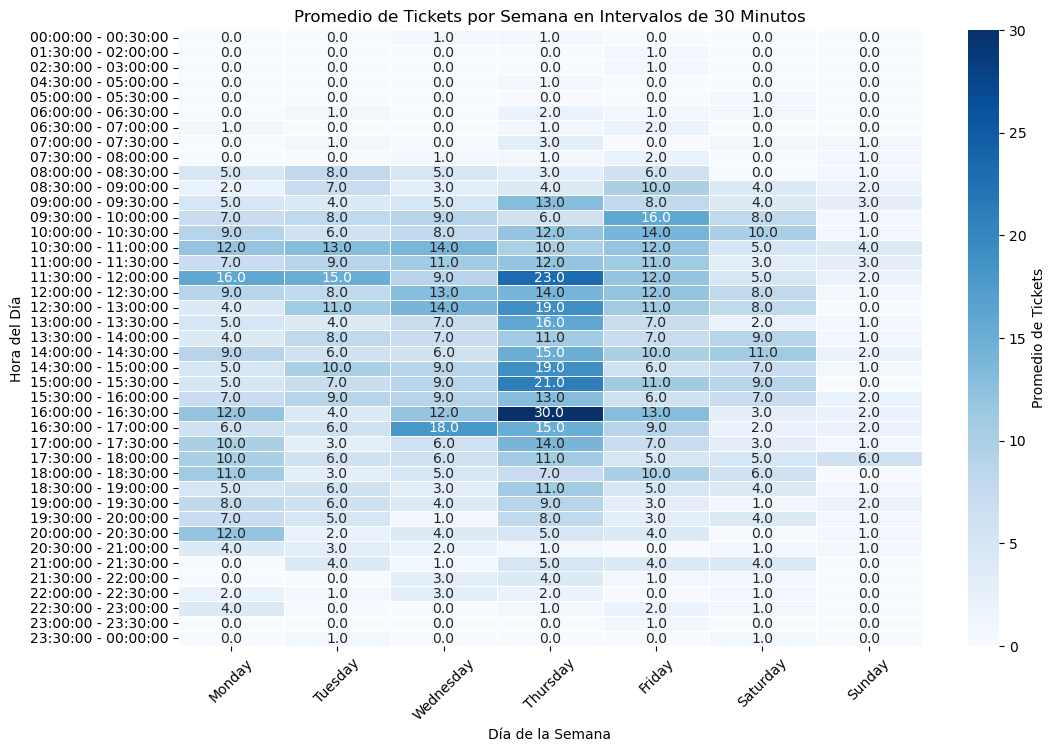

In [124]:

df=df_reporte
# Filtrar datos
df = df[df['Campaña'] == "Canal Digital"]
df = df[df['Tipo de interacción'] == "Entrante"]
df = df[df['Cola Asignada'] == "ATCDigital"]
df = df.dropna(subset=["Fecha y hora de creación del ticket", "Tiempo de resolución de ticket"])


df["Fecha y hora de creación del ticket"] = pd.to_datetime(df["Fecha y hora de creación del ticket"], errors="coerce")


df["Semana"] = df["Fecha y hora de creación del ticket"].dt.isocalendar().week
time_intervals = pd.date_range("00:00:00", "23:30:00", freq="30min").time
df["Hora"] = df["Fecha y hora de creación del ticket"].dt.floor("30T")

df["hora_30m"] = df["Hora"].dt.strftime('%H:%M:%S') + " - " + (df["Hora"] + pd.Timedelta(minutes=30)).dt.strftime('%H:%M:%S')
df["Día"] = df["Fecha y hora de creación del ticket"].dt.day_name()


dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Día"] = pd.Categorical(df["Día"], categories=dias_orden, ordered=True)

result = df.groupby(["Semana", "hora_30m", "Día"]).size().reset_index(name="Tickets")
promedio_tickets = result.groupby(["hora_30m", "Día"])["Tickets"].mean().reset_index()


df_cant_tickets = promedio_tickets.pivot(index="hora_30m", columns="Día", values="Tickets")
df_cant_tickets.index.name = "hora_30m"

# Graficar
plt.figure(figsize=(12, 8))
sns.heatmap(df_cant_tickets, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Promedio de Tickets'})
plt.title("Promedio de Tickets por Semana en Intervalos de 30 Minutos")
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Promedio de número de tickets recibidos por cada 1 hora en la semana

/tmp/ipykernel_180/4278055331.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["Hora"] = df["Fecha y hora de creación del ticket"].dt.floor("60T")
/tmp/ipykernel_180/4278055331.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(["Semana", "hora_60m", "Día"]).size().reset_index(name="Tickets")
/tmp/ipykernel_180/4278055331.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_tickets = result.groupby(["hora_60m", "Día"])["Tickets"].mean().reset_index()


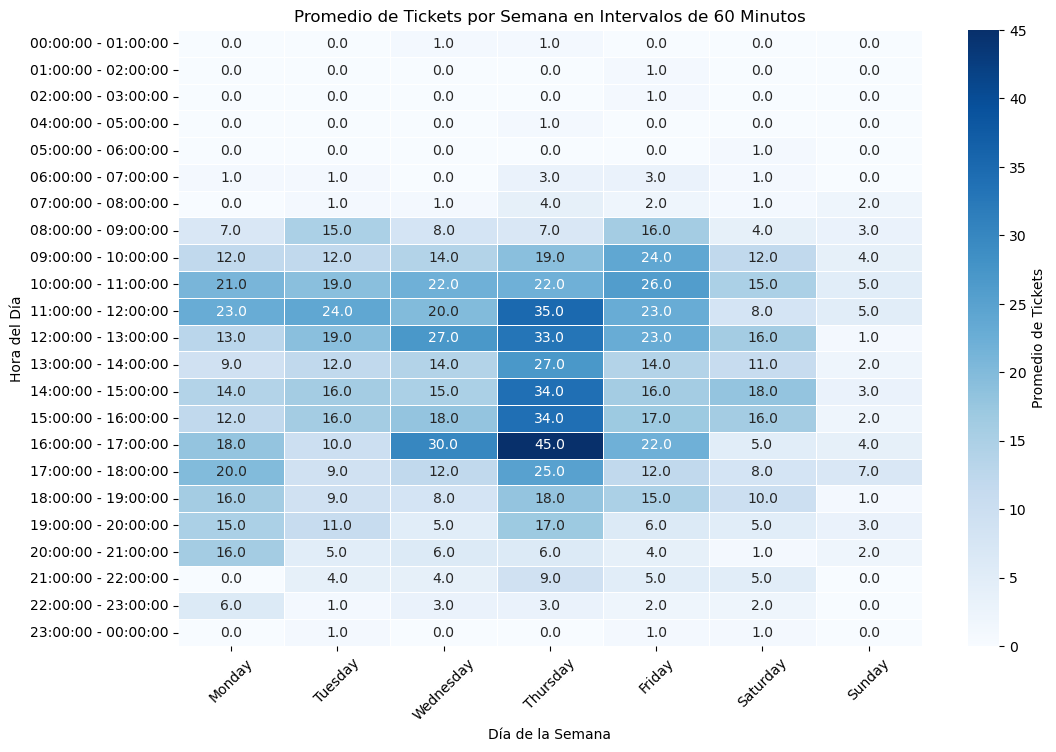

In [68]:

df=df_reporte
# Filtrar datos
df = df[df['Campaña'] == "Canal Digital"]
df = df[df['Tipo de interacción'] == "Entrante"]
df = df[df['Cola Asignada'] == "ATCDigital"]
df = df.dropna(subset=["Fecha y hora de creación del ticket", "Tiempo de resolución de ticket"])


df["Fecha y hora de creación del ticket"] = pd.to_datetime(df["Fecha y hora de creación del ticket"], errors="coerce")


df["Semana"] = df["Fecha y hora de creación del ticket"].dt.isocalendar().week
time_intervals = pd.date_range("00:00:00", "23:30:00", freq="360min").time
df["Hora"] = df["Fecha y hora de creación del ticket"].dt.floor("60T")

df["hora_60m"] = df["Hora"].dt.strftime('%H:%M:%S') + " - " + (df["Hora"] + pd.Timedelta(minutes=60)).dt.strftime('%H:%M:%S')
df["Día"] = df["Fecha y hora de creación del ticket"].dt.day_name()


dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Día"] = pd.Categorical(df["Día"], categories=dias_orden, ordered=True)

result = df.groupby(["Semana", "hora_60m", "Día"]).size().reset_index(name="Tickets")
promedio_tickets = result.groupby(["hora_60m", "Día"])["Tickets"].mean().reset_index()


df_cant_tickets = promedio_tickets.pivot(index="hora_60m", columns="Día", values="Tickets")
df_cant_tickets.index.name = "hora_60m"

# Graficar
plt.figure(figsize=(12, 8))
sns.heatmap(df_cant_tickets, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Promedio de Tickets'})
plt.title("Promedio de Tickets por Semana en Intervalos de 60 Minutos")
plt.xlabel("Día de la Semana")
plt.ylabel("Hora del Día")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Ratio: Dividir el número de tickets con número de agentes

In [125]:
print(df_cant_tickets_60) #de 60min
print(df_cant_agentes_60) #de 60 min
df_ratio_60 = df_cant_tickets_60/df_cant_agentes_60
print(df_ratio_60)

Día                  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
hora_60m                                                                      
00:00:00 - 01:00:00     0.0      0.0        1.0       1.0     0.0       0.0   
01:00:00 - 02:00:00     0.0      0.0        0.0       0.0     1.0       0.0   
02:00:00 - 03:00:00     0.0      0.0        0.0       0.0     1.0       0.0   
04:00:00 - 05:00:00     0.0      0.0        0.0       1.0     0.0       0.0   
05:00:00 - 06:00:00     0.0      0.0        0.0       0.0     0.0       1.0   
06:00:00 - 07:00:00     1.0      1.0        0.0       3.0     3.0       1.0   
07:00:00 - 08:00:00     0.0      1.0        1.0       4.0     2.0       1.0   
08:00:00 - 09:00:00     7.0     15.0        8.0       7.0    16.0       4.0   
09:00:00 - 10:00:00    12.0     12.0       14.0      19.0    24.0      12.0   
10:00:00 - 11:00:00    21.0     19.0       22.0      22.0    26.0      15.0   
11:00:00 - 12:00:00    23.0     24.0       20.0     

<Axes: xlabel='Día', ylabel='hora_60m'>

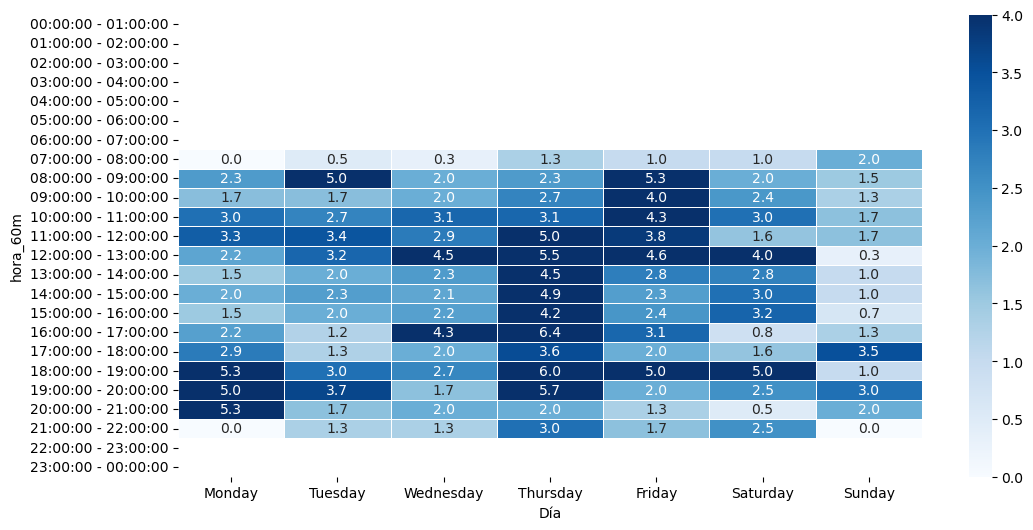

In [73]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_ratio_60, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5,vmin=0, vmax=4)